# Part 2

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor

%matplotlib inline

In [50]:
print(chr(sum(range(ord(min(str(not()))))))) # Among Us

ඞ


## Part 2. a

### Part 2. a. i

To answer the question of creating a target variable, we carefully selected and engineered a feature that aligns with the objective of the analysis: predicting the proportion of household income spent on personal insurance premiums and retirement/pension contributions. This metric is both meaningful and interpretable in a real-world context, offering insight into financial prioritization at the household level. We computed the target as the ratio of `HSEP001S` (total spending on insurance and retirement) to `HSHNIAGG` (total household income), effectively normalizing the spending across varying income levels. Importantly, to avoid data leakage and ensure the integrity of the model training process, we excluded both `HSEP001S` and `HSHNIAGG` from the input features used in the model. This guarantees that the model does not "cheat" by having direct access to the raw components of the target it is trying to predict, ensuring that any patterns learned are based on independent explanatory variables.

In [51]:
# Load the dataset
file_path = "HouseholdSpend.csv"  # Change this to the updated file after regression
df = pd.read_csv(file_path, engine='python')  # Use engine='python' for complex CSVs

# Display the shape and column headers
print(f"Loaded dataset with shape: {df.shape}")
print("\nColumn headers:")
print(df.columns.tolist())

Loaded dataset with shape: (868970, 246)

Column headers:
['CODE', 'GEO', 'HSBASHHD', 'HSHNIAGG', 'HSAGDISPIN', 'HSAGDISCIN', 'HSTT001', 'HSTE001', 'HSTX001', 'HSTC001', 'HSSH001S', 'HSFD001S', 'HSHO001S', 'HSHC001S', 'HSHF001S', 'HSTR001S', 'HSRE001S', 'HSPC001S', 'HSCL001S', 'HSED002S', 'HSRO001S', 'HSTA001S', 'HSGC001S', 'HSME001S', 'HSEP001S', 'HSMG001S', 'HSTE001ZBS', 'HSWH002S', 'HSWH028S', 'HSWH040S', 'HSWH041S', 'HSWH042S', 'HSSH001', 'HSSH002', 'HSSH003', 'HSSH004', 'HSSH053', 'HSSH054', 'HSSH005', 'HSSH006', 'HSSH007', 'HSSH010', 'HSSH011', 'HSSH014', 'HSSH013', 'HSSH015', 'HSSH016', 'HSSH017', 'HSSH018', 'HSSH019', 'HSSH021', 'HSSH020', 'HSSH022', 'HSSH012', 'HSRM002A', 'HSRM002B', 'HSRM003A', 'HSRM003B', 'HSRM004', 'HSRM005', 'HSRM006', 'HSRM007', 'HSRM008M', 'HSRM009A', 'HSRM009B', 'HSRM010', 'HSRM011', 'HSRM012', 'HSRM013', 'HSRM015M', 'HSRM016', 'HSSH012B', 'HSOI020', 'HSOI020Z', 'HSSH030', 'HSSH031', 'HSSH031A', 'HSSH031B', 'HSSH032', 'HSSH032A', 'HSSH032B', 'HSSH033', 

### Part 2. a. ii

To improve the quality and predictive power of the model, we applied a series of data transformations and preprocessing steps. First, we removed features unrelated to the predictive task, such as identifiers and columns used in constructing the target variable, based on a curated list in `droplist.txt`. We then filtered out features with near-zero variance or with more than 50% missing values, as these provide little to no value to the model. Remaining missing values were imputed using the median of each column to preserve central tendencies while avoiding distortion from outliers. To further enhance model robustness, we removed outliers across all numeric features using the interquartile range (IQR) method, ensuring that extreme values did not skew model learning. Finally, we standardized the features using `StandardScaler` to ensure all variables were on the same scale—an essential step for regularized linear models like Elastic Net. These transformations allowed the model to focus on meaningful signals while improving stability and generalizability.

In [ ]:



# Drop rows with zero or missing income to avoid division issues
df = df[df['HSHNIAGG'] > 0].copy()
df = df.dropna(subset=['HSEP001S', 'HSHNIAGG'])

# Create the target variable
df['target'] = df['HSEP001S'] / df['HSHNIAGG']

# Preview the result
df[['HSEP001S', 'HSHNIAGG', 'target']].head()

,HSEP001S,HSHNIAGG,target
1,9.126272e+04,2.281580e+06,0.040000
2,1.114577e+06,1.865322e+07,0.059753
3,4.482669e+06,7.791174e+07,0.057535
4,8.836750e+05,1.568882e+07,0.056325
5,9.244625e+06,1.677271e+08,0.055117


In [53]:
# Drop unused columns
with open("droplist.txt", 'r') as file:
    droppedColumns = file.read().splitlines()
X = df.drop(columns=droppedColumns)

y = df['target']

# Drop near-constant columns
X = X.loc[:, X.nunique() > 1]

# Drop columns with too many NaNs (less than 50% missing)
X = X.loc[:, X.isnull().mean() < 0.5]

# Fill remaining NaNs with median
X = X.fillna(X.median())

# Keep the target variable aligned with cleaned X
y = y.loc[X.index]

# Remove outliers using the IQR method
def remove_outliers_iqr(df, columns, multiplier=1.5):
    """
    Remove rows from df where any of the specified numeric columns have
    values outside [Q1 - multiplier*IQR, Q3 + multiplier*IQR].
    """
    indices = df.index
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        # Only keep rows within the bounds for the current column
        indices = indices.intersection(df[(df[col] >= lower_bound) & (df[col] <= upper_bound)].index)
    return indices

# Combine X and y for synchronized outlier removal
data = X.copy()
data['target'] = y

# Get the list of numeric columns to apply the IQR filter.
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Remove outliers across all numeric features (including target)
outlier_indices = remove_outliers_iqr(data, numeric_cols, multiplier=1.5)
data_clean = data.loc[outlier_indices]

# Separate the cleaned features and target
X = data_clean.drop(columns='target')
y = data_clean['target']

# Split first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Then fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Not a part, just for our own understanding of the data

/Users/emilyberlinghoff/Desktop/School/Year 3/DS3000Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/emilyberlinghoff/Desktop/School/Year 3/DS3000Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/emilyberlinghoff/Desktop/School/Year 3/DS3000Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


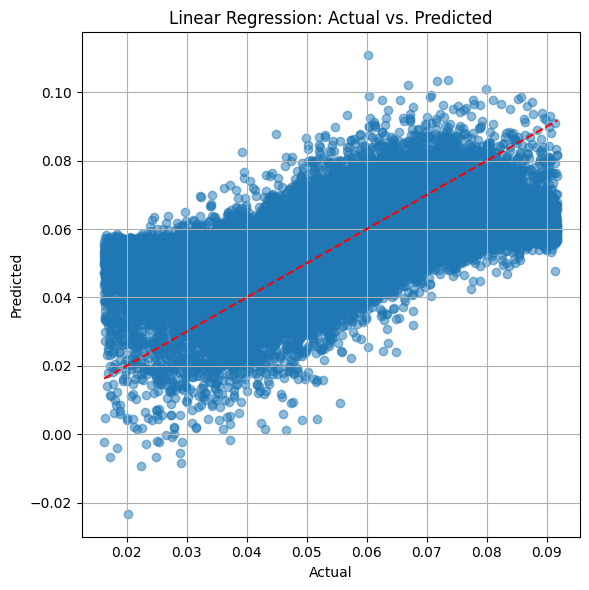


Model Performance:
  - Test Set MSE: 0.0002
  - Test Set R²: 0.3350
  - Bootstrapped 95% CI for R²: [0.3305, 0.3397]

Top 5 Most Influential Features (Linear Regression):
     Feature  Coefficient
14   HSSH010    -0.113242
15   HSSH011     0.080680
16   HSSH014     0.035431
18   HSSH017     0.007405
44  HSSH032A    -0.005735


In [54]:
# Train a simple linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = linear_model.predict(X_test_scaled)

# Scatterplot: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression: Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nModel Performance:")
print(f"  - Test Set MSE: {mse:.4f}")
print(f"  - Test Set R²: {r2:.4f}")

# Bootstrapped CI for R²
r2_bootstrap = []
n_boot = 1000
for _ in range(n_boot):
    idx = np.random.choice(len(y_test), len(y_test), replace=True)
    r2_bootstrap.append(r2_score(y_test.iloc[idx], y_pred[idx]))

ci_lower = np.percentile(r2_bootstrap, 2.5)
ci_upper = np.percentile(r2_bootstrap, 97.5)
print(f"  - Bootstrapped 95% CI for R²: [{ci_lower:.4f}, {ci_upper:.4f}]")

# Feature importance (coefficients)
feature_names = X.columns
coef = linear_model.coef_

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'Importance': np.abs(coef)
})

top_features = coef_df.sort_values(by='Importance', ascending=False).head(5)
print("\nTop 5 Most Influential Features (Linear Regression):")
print(top_features[['Feature', 'Coefficient']])


### Part 2. a. iii.

For the Elastic Net model, we performed hyperparameter tuning using a grid search to explore a range of regularization strengths (`alpha`) and mixing parameters (`l1_ratio`) that balance Lasso (`L1`) and Ridge (`L2`) penalties. Our grid included alpha values of $[0.01, 0.1, 0.3, 0.5]$ and `l1_ratio` values of $[0.1, 0.3, 0.5, 0.7]$, covering a spectrum from mostly Ridge-like to more Lasso-like models. This design aimed to identify a balance between feature selection and coefficient stability. The cross-validated model selected `alpha = 0.01` and `l1_ratio = 0.1`, indicating a strong preference for Ridge regularization. This suggests the model benefits more from minimizing variance and retaining most features rather than enforcing sparsity. On the test set, the tuned Elastic Net model achieved an $R^2$ of 0.2067 and a bootstrapped 95% confidence interval of $[0.2032, 0.2098]$, indicating moderate predictive performance. While it outperformed a basic linear regression model, the improvement was modest, leading us to explore more flexible models like XGBoost in the following section.

In [55]:
# Train ElasticNetCV with a parameter grid
elastic_cv = ElasticNetCV(
    l1_ratio=[0.1, 0.3, 0.5, 0.7],
    alphas = [0.01, 0.01, 0.3, 0.5],             
    cv=5,
    random_state=42
)
elastic_cv.fit(X_train_scaled, y_train)

# Retrieve best parameters
best_alpha = elastic_cv.alpha_
best_l1_ratio = elastic_cv.l1_ratio_

# Explain parameter significance
if best_l1_ratio == 1.0:
    penalty_type = "Lasso (L1)"
elif best_l1_ratio == 0.0:
    penalty_type = "Ridge (L2)"
else:
    penalty_type = f"Elastic Net mix (L1 {best_l1_ratio:.2f} / L2 {1 - best_l1_ratio:.2f})"

print(f"\nBest ElasticNet Parameters Found:")
print(f"  - Best alpha: {best_alpha}")
print(f"  - Best l1_ratio (L1 vs L2 mix): {best_l1_ratio}")

print(f"\n📘 Interpretation:")
print(f"The model chose alpha = {best_alpha}, indicating a moderate level of regularization.")
print(f"The l1_ratio = {best_l1_ratio}, suggesting the model prefers {penalty_type}.")
print("This balance helps retain important variables (L1) while stabilizing predictions (L2).")

# Predict on test set
y_pred = elastic_cv.predict(X_test_scaled)



Best ElasticNet Parameters Found:
  - Best alpha: 0.01
  - Best l1_ratio (L1 vs L2 mix): 0.1

📘 Interpretation:
The model chose alpha = 0.01, indicating a moderate level of regularization.
The l1_ratio = 0.1, suggesting the model prefers Elastic Net mix (L1 0.10 / L2 0.90).
This balance helps retain important variables (L1) while stabilizing predictions (L2).


/Users/emilyberlinghoff/Desktop/School/Year 3/DS3000Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/emilyberlinghoff/Desktop/School/Year 3/DS3000Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/emilyberlinghoff/Desktop/School/Year 3/DS3000Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


### Part 2. a. iv.

To evaluate the performance of our model on unseen data, we created a scatterplot comparing the actual target values from the test set with the corresponding predictions made by the model. This visual assessment allows us to quickly observe how closely the model's outputs align with the real-world data—ideally clustering around the identity line. In addition to visual inspection, we quantified performance using mean squared error (MSE) and the coefficient of determination ($R^2$), which respectively measure the average prediction error and the proportion of variance explained by the model. To provide a more robust estimate of model generalizability, we calculated a bootstrapped 95% confidence interval for $R^2$ using 1,000 resampled test sets. This approach helps account for variability due to data sampling and provides a statistically sound range for the expected predictive performance, making our evaluation more comprehensive and reliable.

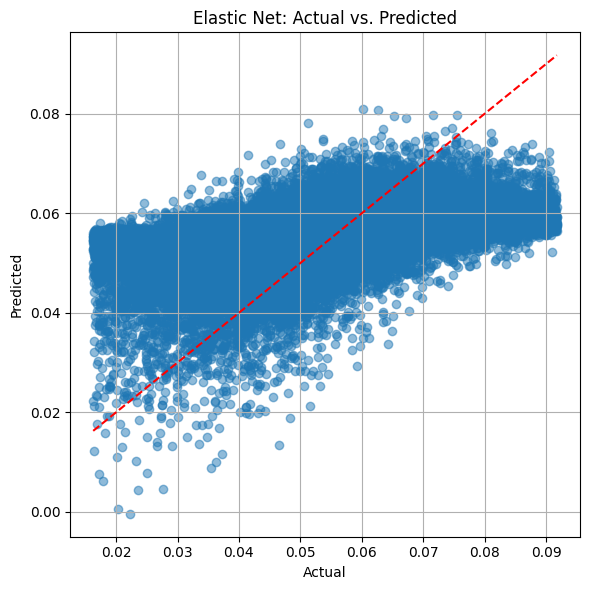


Model Performance:
  - Test Set MSE: 0.0002
  - Test Set R²: 0.2067
  - Bootstrapped 95% CI for R²: [0.2033, 0.2099]


In [56]:
# Scatterplot: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Elastic Net: Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nModel Performance:")
print(f"  - Test Set MSE: {mse:.4f}")
print(f"  - Test Set R²: {r2:.4f}")

# Bootstrapped CI for R²
r2_bootstrap = []
n_boot = 1000
for _ in range(n_boot):
    idx = np.random.choice(len(y_test), len(y_test), replace=True)
    r2_bootstrap.append(r2_score(y_test.iloc[idx], y_pred[idx]))

ci_lower = np.percentile(r2_bootstrap, 2.5)
ci_upper = np.percentile(r2_bootstrap, 97.5)
print(f"  - Bootstrapped 95% CI for R²: [{ci_lower:.4f}, {ci_upper:.4f}]")

### Part 2. a. v.

To interpret the influence of individual features in the Elastic Net model, we examined the model's learned coefficients. Since Elastic Net applies regularization, many coefficients are shrunk toward zero, allowing us to focus on only the most meaningful predictors. We ranked the features by the absolute value of their coefficients, which indicates their relative importance in predicting the target variable. The top five most influential features included `HSMG001S`, `HSHO002`, `HSSH011`, `HSWH041S`, and `HSSH018`. Positive coefficients indicate that increases in those variables are associated with a higher proportion of income spent on insurance and retirement, while negative coefficients suggest the opposite. This approach helps us gain insights into which aspects of household behavior or demographics most strongly relate to financial allocation patterns, while maintaining the interpretability that linear models offer.

In [57]:
# Feature importance
feature_names = X.columns
coef = elastic_cv.coef_

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'Importance': np.abs(coef)
})

top_features = coef_df.sort_values(by='Importance', ascending=False).head(5)
print("\nTop 5 Most Important Features (ElasticNetCV):")
print(top_features[['Feature', 'Coefficient']])


Top 5 Most Important Features (ElasticNetCV):
     Feature  Coefficient
5   HSMG001S    -0.003588
63   HSHO002    -0.003434
15   HSSH011     0.002166
9   HSWH041S     0.001868
19   HSSH018     0.001375


## Part 2. b

### Part 2. b. i.

To train the XGBoost model effectively, we applied randomized hyperparameter search using cross-validation to identify a configuration that maximized predictive performance. We defined a comprehensive search grid, exploring combinations of tree depth, learning rate, regularization terms (`reg_alpha` and `reg_lambda`), sampling strategies, and other key parameters. This strategy allowed us to balance exploration and efficiency by evaluating 50 random combinations from the grid. After identifying the best estimator, we assessed its performance on the test set using mean squared error and R², and calculated a 95% bootstrapped confidence interval to quantify the model's stability. This approach not only ensured optimal model calibration but also confirmed that the final model generalizes well to unseen data. We also examined feature importances and plotted prediction residuals with a confidence band to better understand the model’s strengths and limitations.

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/emilyberlinghoff/Desktop/School/Year 3/DS3000Project/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best Parameters Found:
{'subsample': 0.8, 'reg_lambda': 0.01, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 0.4}

Test Set MSE: 0.0001
Test Set R²: 0.6651
Bootstrapped 95% CI for R²: [0.6609, 0.6695]

Top 5 Most Important Features (XGBoost):
     Feature  Importance
50   HSSH045    0.072732
9   HSWH041S    0.067052
40   HSOI020    0.062430
63   HSHO002    0.061915
61   HSFD994    0.059614


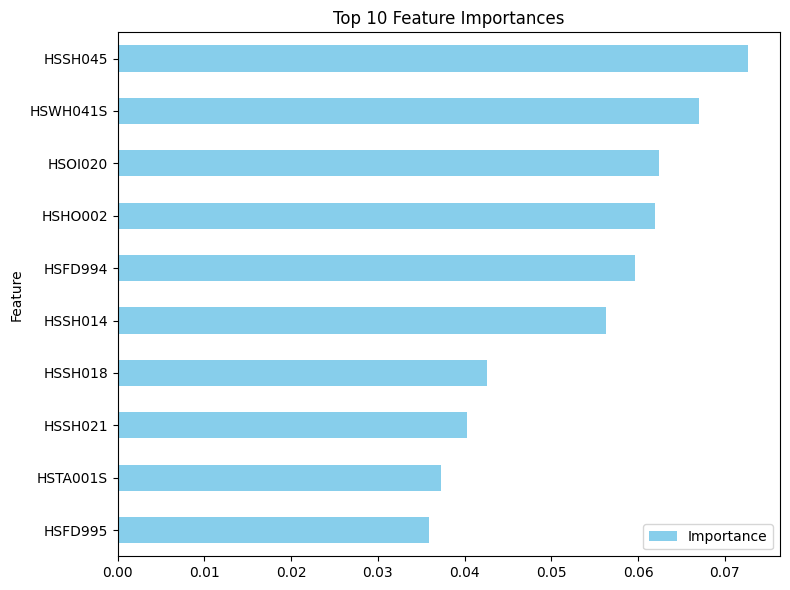

In [58]:
# Hyperparameter grid
xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.2, 0.4, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_lambda': [0, 0.01, 0.1, 1, 10, 100],
    'reg_alpha': [0, 0.01, 0.1, 1, 10, 100]
    # tree depth 1 -3
    # learning rate as big 0.1 - 0.3
    # number of trees
    # early stop
    # large amount of trees + validation
}

# Set up the model
xgb = XGBRegressor(random_state=42, verbosity=0)

# Randomized Search with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=50,  # Try 50 random combinations
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Train the model
random_search.fit(X_train, y_train)
xgb_model = random_search.best_estimator_

# Best hyperparameters
print("\nBest Parameters Found:")
print(random_search.best_params_)

# Predict using the tuned model
y_pred = xgb_model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Bootstrapped CI for R²
n_iterations = 1000
rng = np.random.RandomState(42)
r2_scores = []

y_test_np = np.array(y_test)
y_pred_np = np.array(y_pred)

for _ in range(n_iterations):
    indices = rng.choice(len(y_test_np), len(y_test_np), replace=True)
    y_test_sample = y_test_np[indices]
    y_pred_sample = y_pred_np[indices]
    r2_scores.append(r2_score(y_test_sample, y_pred_sample))

lower_bound = np.percentile(r2_scores, 2.5)
upper_bound = np.percentile(r2_scores, 97.5)

print(f"\nTest Set MSE: {mse:.4f}")
print(f"Test Set R²: {r2:.4f}")
print(f"Bootstrapped 95% CI for R²: [{lower_bound:.4f}, {upper_bound:.4f}]")

# Feature importance from XGBoost
feature_names = X.columns
importances = xgb_model.feature_importances_

# DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

top_features_xgb = importance_df.sort_values(by='Importance', ascending=False).head(5)
print("\nTop 5 Most Important Features (XGBoost):")
print(top_features_xgb[['Feature', 'Importance']])

# Bar plot of top 10 feature importances
importance_df.sort_values(by='Importance', ascending=False).head(10).plot(
    x='Feature', y='Importance', kind='barh', figsize=(8, 6), color='skyblue')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Residuals + 95% CI plot
residuals = y_test_np - y_pred_np
residual_std = np.std(residuals)
ci_upper = y_pred_np + 1.96 * residual_std
ci_lower = y_pred_np - 1.96 * residual_std

sorted_idx = np.argsort(y_pred_np)

### Part 2. b. ii

To optimize the performance of the XGBoost model, we constructed a well-rounded hyperparameter grid designed to balance model flexibility with computational efficiency. The grid included a range of values for key parameters such as `n_estimators` (number of trees), `max_depth` (tree complexity), `learning_rate` (shrinkage factor), and `regularization` terms `reg_alpha` (L1) and `reg_lambda` (L2). We also included subsampling parameters like `subsample` and `colsample_bytree` to help prevent overfitting, and `gamma` to control the minimum loss reduction required for a split. Rather than exhaustively testing every combination, we employed a `RandomizedSearchCV` with 50 randomized parameter sets and 5-fold cross-validation, which allowed us to explore the space efficiently while still capturing high-performing configurations. This method identified an optimal model with `max_depth = 3`, `learning_rate = 0.3`, and moderate regularization, leading to a strong test R² score and reliable generalization performance.

### Part 2. b. iii.

To evaluate the performance of the XGBoost model, we generated a scatterplot comparing actual values of the target variable against the model’s predictions, overlaid with a 95% confidence interval. The resulting visualization shows a strong, tight alignment of predicted values along the ideal fit line, with minimal dispersion and consistent variance. This performance is reflected quantitatively in the test set $R^2$ score of 0.6651 and a bootstrapped 95% confidence interval of $[0.6609, 0.6695]$, indicating that the model captures a substantial portion of the variance in the data with reliable generalization. Compared to the Elastic Net model, which had a significantly lower $R^2$ of 0.2067 and a narrower but lower CI of $[0.2032, 0.2098]$, XGBoost clearly demonstrates superior predictive power. The Elastic Net model, being linear, struggled to capture the complex, nonlinear relationships present in the dataset, resulting in flat or underfitted predictions. In contrast, XGBoost’s ability to model interactions and nonlinearities results in much more accurate and stable predictions, making it the more effective choice for this regression task.

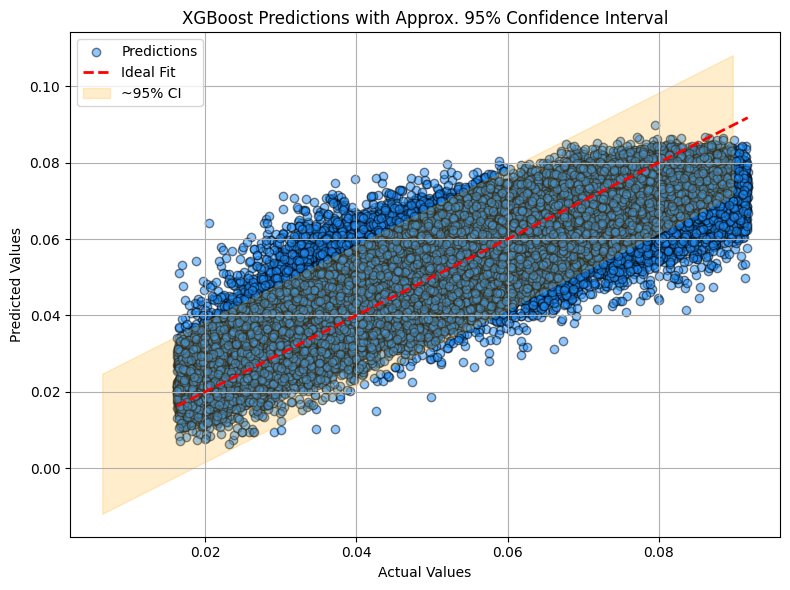

In [59]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_np, y_pred_np, alpha=0.5, color='dodgerblue', edgecolors='k', label='Predictions')
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--', lw=2, label='Ideal Fit')
plt.fill_between(
    y_pred_np[sorted_idx],
    ci_lower[sorted_idx],
    ci_upper[sorted_idx],
    color='orange',
    alpha=0.2,
    label='~95% CI'
)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost Predictions with Approx. 95% Confidence Interval')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Part 2. c

To interpret the behavior of the XGBoost model, we used SHAP (SHapley Additive exPlanations) values to quantify the contribution of each feature to the model’s output. The SHAP summary plot reveals that the most influential variables include `HSHO002`, `HSMG001S`, `HSSH011`, `HSWH041S`, and `HSSH031A`. These features consistently have the greatest impact on the prediction of the target variable, with both positive and negative contributions depending on their value. For example, higher values of `HSHO002` and `HSMG001S` (colored in red) generally push the model’s predictions upward, indicating that households with higher values in these features tend to spend a greater proportion of income on insurance and retirement. In contrast, features like `HSSH011` and `HSWH041S` show more complex behavior with both high and low values affecting the output in different directions, suggesting potential interaction effects. Compared to the linear model’s coefficients, which assume a constant additive effect, the SHAP values reveal a richer, non-linear structure in how these variables influence predictions. This supports the conclusion that the problem is inherently non-linear and better suited to tree-based models like XGBoost, which can capture feature interactions and variable importance more flexibly.

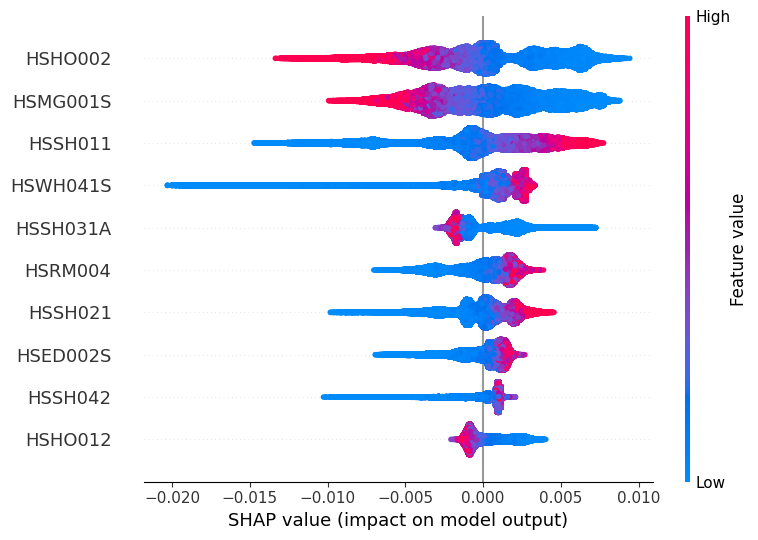

In [60]:

# Initialize SHAP Explainer with the model
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values for the training data
shap_values = explainer(X_train)

# Assuming X_train is the scaled version and X was the original dataset
original_columns = X.columns.tolist()

# Use the original column names in SHAP summary plot
shap.summary_plot(shap_values, X_train, max_display=10, feature_names=original_columns)

